In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')

from nltk.tokenize import word_tokenize, sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Классификация фамилий по национальности (ConvNet)

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)
  * добавьте в словарь специальный токен `<PAD>` с индексом 0
  * при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута `max_seq_len`

2.5 Реализовать класс `SurnamesDataset`
  * метод `__getitem__` возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса> 
  * длина каждой такой последовательности должна быть одинаковой и равной `vocab.max_seq_len`. Чтобы добиться этого, дополните последовательность справа индексом токена `<PAD>` до нужной длины

2.6. Обучить классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`. Рассмотрите два варианта: 
    - когда токен представляется в виде унитарного вектора и модуль `nn.Embedding` не обучается
    - когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### 2.1 Считать файл surnames/surnames.csv

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/surnames.csv')
data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### 2.2 Закодировать национальности числами, начиная с 0.

In [ ]:
lst = data.nationality.unique()
le = LabelEncoder()
le.fit(lst)
for i in range(len(data)):
  data.nationality[i] = le.transform([data.nationality[i]]).item()


In [ ]:
data.head()

,surname,nationality
0,Woodford,4
1,Coté,5
2,Kore,4
3,Koury,0
4,Lebzak,14


### 2.3 Разбить датасет на обучающую и тестовую выборку

In [ ]:
X = data.surname.values
y = data.nationality.values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Training Data: ", len(x_train))
print("Testing Data: ", len(x_test))

Training Data:  8784
Testing Data:  2196


In [ ]:
y_test.shape

(2196,)

### 2.4 Реализовать класс Vocab (токен = символ)

добавьте в словарь специальный токен <PAD> с индексом 0


при создании словаря сохраните длину самой длинной последовательности из набора данных в виде атрибута max_seq_len

In [ ]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    for surname in data:
      tokens.update(surname)

    self.idx_to_token = {(idx+1): token for idx, token in enumerate(tokens)}
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}

    self.idx_to_token[0] = '<PAD>'
    self.token_to_idx['<PAD>'] = 0

    self.vocab_len = len(self.idx_to_token)
    self.max_seq_len = len(max(list(data), key=len))

In [ ]:
v = Vocab(X)
print(v.vocab_len)
print(v.max_seq_len)

85
17


In [ ]:
print(v.token_to_idx['<PAD>'])
print(v.idx_to_token[41])

0
j


### 2.5 Реализовать класс SurnamesDataset

метод __getitem__ возвращает пару: <последовательность индексов токенов (см. 1.1 ), номер класса>


длина каждой такой последовательности должна быть одинаковой и равной vocab.max_seq_len. Чтобы добиться этого, дополните последовательность справа индексом токена <PAD> до нужной длины

In [ ]:
torch.zeros(2, v.max_seq_len)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
class SurnamesDataset(Dataset):
  def __init__(self, X: pd.Series, y, vocab: Vocab):
    self.X = X 
    self.y = y
    self.vocab = vocab

  def vectorize(self, surname: str):
    surname_t = torch.zeros(1, self.vocab.max_seq_len)

    for i, s in enumerate(surname):
      surname_t[:,i] = self.vocab.token_to_idx[s]
    
    return surname_t.flatten()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx] 

### 2.6. Обучить классификатор.

Для преобразования последовательности индексов в последовательность векторов используйте nn.Embedding. Рассмотрите два варианта:

- когда токен представляется в виде унитарного вектора и модуль nn.Embedding не обучается

- когда токен представляется в виде вектора небольшой размерности (меньше, чем размер словаря) и модуль nn.Embedding обучается

Используйте одномерные свертки и пулинг (nn.Conv1d, nn.MaxPool1d)

обратите внимание, что nn.Conv1d ожидает на вход трехмерный тензор размерности (batch, embedding_dim, seq_len)

In [ ]:
surnames_train = SurnamesDataset(x_train, y_train, v)
surnames_test = SurnamesDataset(x_test, y_test, v)

s_dataloader_train = DataLoader(surnames_train, batch_size = 64, shuffle=True)
s_dataloader_test = DataLoader(surnames_test, batch_size = 64, shuffle=True)

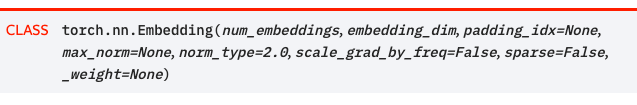

In [ ]:
import numpy as np

In [ ]:
# creating model
input = v.vocab_len
output = len(set(y_test))

model = nn.Sequential(nn.Embedding(v.vocab_len, v.max_seq_len),
                        nn.Conv1d(v.max_seq_len, 20, 2),
                        nn.BatchNorm1d(20),
                        nn.ReLU(),
                        nn.MaxPool1d(2),
                        nn.Flatten(),
                        nn.Linear(160, 50),
                        nn.ReLU(),
                        nn.Linear(50, output))  ######


loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses = []

n_epoch = 100
for epoch in range(n_epoch):
  for X_batch, y_batch in s_dataloader_train:
    
    X_batch = X_batch.view(-1, v.max_seq_len).long()
    out = model(X_batch)

    # loss
    batch_loss = loss(out, y_batch)

    # backward
    batch_loss.backward()

    # optimization
    curr_loss = []
    optimizer.step()
    optimizer.zero_grad()
    curr_loss.append(batch_loss.item())
  losses.append(np.mean(curr_loss))
  if epoch%10 == 0:
    print(f"Epoch: {epoch}, loss: {losses[-1]}")

Epoch: 0, loss: 1.8467085361480713
Epoch: 10, loss: 1.412166714668274
Epoch: 20, loss: 0.693393349647522
Epoch: 30, loss: 1.3825749158859253
Epoch: 40, loss: 0.5938098430633545
Epoch: 50, loss: 1.2367278337478638
Epoch: 60, loss: 0.19359037280082703
Epoch: 70, loss: 0.18131624162197113
Epoch: 80, loss: 0.7271075248718262
Epoch: 90, loss: 0.5953967571258545


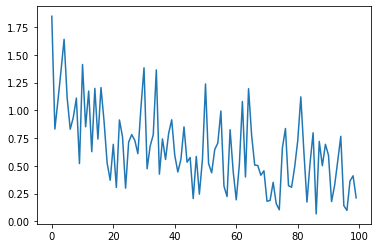

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
# Train Accuracy
correct, total = 0, 0
with torch.no_grad():
  for surname, labels in s_dataloader_train:
    batch_size = surname.shape[0]
    
    out = model(surname.view(batch_size, -1).long())
    _, predicted = torch.max(out, dim=1)
    
    total += labels.shape[0]
    correct += int((predicted == labels).sum())
print(f'Train Accuracy: {correct / total}')


# Test Accuracy
correct1, total1 = 0, 0
with torch.no_grad():
  for surname, labels in s_dataloader_test:
    batch_size = surname.shape[0]

    out = model(surname.view(batch_size, -1).long())
    _, predicted = torch.max(out, dim=1)

    total1 += labels.shape[0]
    correct1 += int((predicted == labels).sum())
print(f'Test Accuracy: {correct1 / total1}')

Train Accuracy: 0.9035746812386156
Test Accuracy: 0.6885245901639344


### 2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
surname = 'Ermolina'
s = torch.Tensor(surnames_train.vectorize(surname)).view(1,-1)

with torch.no_grad():
    batch_size = s.shape

    out = model.forward(s.view(batch_size, -1).long())

    _, predicted = torch.max(out, dim=1)
    _, predicted1 = torch.topk(out,3, dim=1)

    #values, indices = out.topk(3, dim=1)
    #values, indices = out

    pred = predicted
    pred1 = predicted1
    print(pred)
    print(pred1)

print('Top prediction:', le.inverse_transform(pred)[0])
print(f'Top1 is {le.inverse_transform([int(pred1[0][0].item())])[0]}, top2 is {le.inverse_transform([int(pred1[0][1].item())])[0]}, top3 is {le.inverse_transform([int(pred1[0][2].item())])[0]}')

tensor([14])
tensor([[14,  9,  4]])
Top prediction: Russian
Top1 is Russian, top2 is Italian, top3 is English


## 3. Классификация обзоров на фильмы (ConvNet)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте одномерные свертки и пулинг (`nn.Conv1d`, `nn.MaxPool1d`)
    - обратите внимание, что `nn.Conv1d` ожидает на вход трехмерный тензор размерности `(batch, embedding_dim, seq_len)`


2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

### 2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.

- токен = слово

- данные для обучения в датасете представляются в виде последовательности индексов токенов

- словарь создается на основе только обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен <UNK>
добавьте предобработку текста

In [ ]:
positive = pd.read_csv('/content/drive/MyDrive/datasets/positive_reviews.txt', delimiter = "\t", header = None, names = ['review'])
positive['mark'] = [1] * len(positive)

negative = pd.read_csv('/content/drive/MyDrive/datasets/negative_reviews.txt', delimiter = "\t", header = None, names = ['review'])
negative['mark'] = [0] * len(negative)


In [ ]:
positive.head()

,review,mark
0,"simplistic , silly and tedious .",1
1,"it's so laddish and juvenile , only teenage bo...",1
2,exploitative and largely devoid of the depth o...,1
3,[garbus] discards the potential for pathologic...,1
4,a visually flashy but narratively opaque and e...,1


In [ ]:
positive.shape

(5331, 2)

In [ ]:
data = pd.concat([negative, positive], axis = 0)
data.head()

,review,mark
0,the rock is destined to be the 21st century's ...,0
1,"the gorgeously elaborate continuation of "" the...",0
2,effective but too-tepid biopic,0
3,if you sometimes like to go to the movies to h...,0
4,"emerges as something rare , an issue movie tha...",0


In [ ]:
import re
def preprocess_text(text):
    
    text = text.lower()
 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) 
    text = re.sub('[^a-zA-z]+', ' ', text)
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub(' +', ' ', text)

    return text.strip()

In [ ]:
X = data['review'].values
X = [preprocess_text(t) for t in X]
y = data['mark'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, 
                                                    random_state = 42)

print('Yelp len', len(X))
print('Train len', len(x_train))
print('Train len', len(y_train))
print('Test len', len(x_test))

Yelp len 10662
Train len 8529
Train len 8529
Test len 2133


In [ ]:
x_train[:10]

['don michael paul uses quick cuts very large shadows and wide angle shots taken from a distance to hide the liberal use of a body double for seagal',
 'such a premise is ripe for all manner of lunacy but kaufman and gondry rarely seem sure of where it should go',
 'just an average comedic dateflick but not a waste of time',
 'for those of an indulgent slightly sunbaked and summery mind sex and lucia may well prove diverting enough',
 'has an unmistakable easy joie de vivre',
 'nicholson s understated performance is wonderful as warren he stumbles in search of all the emotions and life experiences he s neglected over the years',
 'a clich d and shallow cautionary tale about the hard partying lives of gay men',
 'lathan and diggs carry the film with their charisma and both exhibit sharp comic timing that makes the more hackneyed elements of the film easier to digest',
 'boomers and their kids will have a barrie good time',
 'about the only thing to give the movie points for is bravado t

### Class Vocab

In [ ]:
import operator
from functools import reduce

In [ ]:
class Vocab:
  def __init__(self, data):
    tokens = set()
    self.max_seq_len = 0
    for review in data:
      tokens.update(word_tokenize(review))
      
      
    self.idx_to_token = {(idx+1): token for idx, token in enumerate(tokens)}

    self.idx_to_token[0] = '<PAD>'
    self.idx_to_token[len(self.idx_to_token)] = '<UNK>'


    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}


    self.vocab_len = len(self.idx_to_token)

  
    temp = [len(word_tokenize(i)) for i in data]
    self.max_seq_len = max(temp)

In [ ]:
v = Vocab(x_train)
print(v.vocab_len)
print(v.max_seq_len)

16389
52


### ReviewDataset

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X 
    self.y = y 
    self.vocab = vocab

  def vectorize(self, review):
    '''Генерирует представление отзыва review в виде bag of words (см. 1.2.1)'''
    review_t = torch.zeros(self.vocab.max_seq_len + 2)  ## из-за  pad и unk
    
    for i, word in enumerate(word_tokenize(review)):
        if i <= self.vocab.max_seq_len:
            if word in list(self.vocab.token_to_idx.keys()):
              review_t[i] = self.vocab.token_to_idx[word]
            else:
              review_t[-1] = self.vocab.token_to_idx['<UNK>']
        else:
           review_t[-2] = self.vocab.token_to_idx['<PAD>']

    return review_t
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.vectorize(self.X[idx]), self.y[idx]

In [ ]:
ReviewDataset(x_train, y_train, v)[1]

(tensor([ 4425., 12014.,   832.,  5013., 15849., 10318., 12184.,  6000.,  2298.,
         12994.,  1160.,  1024.,  9966.,  2583., 11478.,  5841.,  5783.,  2298.,
          7940.,  6707.,   830.,   381.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.]),
 1)

### 3.6 Обучить классификатор

In [ ]:
review_train = ReviewDataset(x_train, y_train, v)
review_test = ReviewDataset(x_test, y_test, v)

r_dataloader_train = DataLoader(review_train, batch_size = 64, shuffle = True)
r_dataloader_test = DataLoader(review_test, batch_size = 64, shuffle = True)

In [ ]:
review_train[0][0].shape

torch.Size([54])

In [ ]:
model_1= nn.Sequential(nn.Embedding(v.vocab_len, v.max_seq_len+2),
                        nn.Conv1d(v.max_seq_len+2, 300, 2),
                        nn.BatchNorm1d(300),
                        nn.ReLU(),
                        nn.MaxPool1d(2))
                        # nn.Flatten(),
                        # nn.Linear(3456, 50),
                        # nn.ReLU(),
                        # nn.Linear(50, output))  ######

In [ ]:
x_batch, y_batch = next(iter(r_dataloader_train))
x_batch = x_batch.view(-1, v.max_seq_len+2).long()
model_1(x_batch).shape  

torch.Size([64, 300, 26])

In [ ]:
for X_batch, y_batch in r_dataloader_train:

    X_batch = X_batch.view(-1, v.max_seq_len).long()
    out = model(X_batch)

In [ ]:
import numpy as np

In [ ]:
input = v.vocab_len
output = len(set(y_test))

model = nn.Sequential(nn.Embedding(v.vocab_len, v.max_seq_len+2),
                        nn.Conv1d(v.max_seq_len+2, 300, 2),
                        nn.BatchNorm1d(300),
                        nn.ReLU(),
                        nn.MaxPool1d(2),
                        nn.Conv1d(300, 100, 2),
                        nn.BatchNorm1d(100),
                        nn.ReLU(),
                        nn.MaxPool1d(2),
                        nn.Flatten(),
                        nn.Linear(1200, 50),
                        nn.ReLU(),
                        nn.Linear(50, output))  ######


loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

n_epoch = 10
for epoch in range(n_epoch):
  for X_batch, y_batch in r_dataloader_train:
    
    # forward
    X_batch = X_batch.view(-1, v.max_seq_len+2).long()
    out = model(X_batch)
    
    # loss
    batch_loss = loss(out, y_batch)
    
    # backward
    batch_loss.backward()

  # optimization
    curr_loss = []
    optimizer.step()
    optimizer.zero_grad()
    curr_loss.append(batch_loss.item())
  losses.append(np.mean(curr_loss))
  #if epoch%10 == 0:
  print(f"Epoch: {epoch}, loss: {losses[-1]}")

Epoch: 0, loss: 0.6936018466949463
Epoch: 1, loss: 0.693688154220581
Epoch: 2, loss: 0.6919589042663574
Epoch: 3, loss: 0.6943435072898865
Epoch: 4, loss: 0.6735219359397888
Epoch: 5, loss: 0.6535554528236389
Epoch: 6, loss: 0.5939276218414307
Epoch: 7, loss: 0.5220785140991211
Epoch: 8, loss: 0.31348228454589844
Epoch: 9, loss: 0.16043336689472198


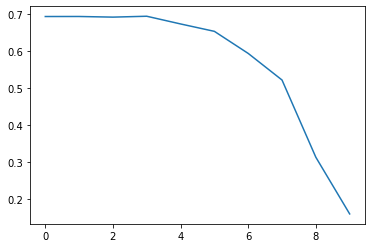

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
# Test Accuracy
correct1, total1 = 0, 0
with torch.no_grad():
  for surname, labels in r_dataloader_test:
    batch_size = surname.shape[0]

    out = model(surname.view(batch_size, -1).long())
    _, predicted = torch.max(out, dim=1)

    total1 += labels.shape[0]
    correct1 += int((predicted == labels).sum())
print(f'Test Accuracy: {correct1 / total1}')

Test Accuracy: 0.60056258790436


In [ ]:
review_pos = 'Wow guys wonderful service! 100% worth visiting. Amazing!'
review_neg = 'Awful. Wont come here again'
neg1 = 'Awful'
pos1 = 'Super cool I liked it'

#pos = torch.Tensor(review_train.vectorize(preprocess_text(review_pos))).view(1,-1)
#neg = torch.Tensor(review_train.vectorize(preprocess_text(review_neg))).view(1,-1)
neg1 = torch.Tensor(review_train.vectorize(preprocess_text(neg1))).view(1,-1)
pos1 = torch.Tensor(review_train.vectorize(preprocess_text(pos1))).view(1,-1)

In [ ]:
data.head()

,review,mark
0,the rock is destined to be the 21st century's ...,0
1,"the gorgeously elaborate continuation of "" the...",0
2,effective but too-tepid biopic,0
3,if you sometimes like to go to the movies to h...,0
4,"emerges as something rare , an issue movie tha...",0


In [ ]:
with torch.no_grad():
    batch_size1 = pos.shape
    batch_size2 = neg.shape

    out1 = model.forward(pos1.view(batch_size1, -1).long())
    out2 = model.forward(neg1.view(batch_size2, -1).long())

    _, predicted1 = torch.max(out1, dim=1)
    _, predicted2 = torch.max(out2, dim=1)

preds = [predicted1, predicted2]
print(preds)
for i in preds:
  if i.item() == 0:
    print('Negative review')
  else: 
    print('Positive review')

[tensor([1]), tensor([1])]
Positive review
Positive review
